# Image reconstruction from similarity invariants — Jupyter Notebook

This notebook is an implementation-oriented reproduction of the main goals of the paper "Image reconstruction from a complete set of similarity invariants extracted from complex moments" (Ghorbel et al., 2006).

It walks through:
- computing complex moments of a discrete image
- building translation/rotation/scale (similarity) invariants from complex moments
- reconstructing a small image from a finite set of invariants by solving the linear inverse problem that links moments and pixel values

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import cv2

EPS = 1e-12

In [3]:
def compute_centroid(image):
    """
    Compute the centroid (x_c, y_c) of a grayscale.
    """
    img = np.asarray(image, dtype=float)
    h, w = img.shape
    m00 = img.sum()
    if abs(m00) < EPS:
        return w/2.0, h/2.0  # fallback for empty image
    X, Y = np.meshgrid(np.arange(w), np.arange(h))
    x_c = (img * X).sum() / m00
    y_c = (img * Y).sum() / m00
    return x_c, y_c

## Complex moments: 
For an integrable function f(x,y), complex moments can be defined by the complex coordinates $z = x + i y$ and $\bar{z} = x - i y$. The complex (discrete) moments can be written as:


$$M_{p,q} = \sum_x \sum_y z^p \bar{z}^q f(x,y)$$

In [4]:
def complex_moments(image, max_order):
    """
    Compute centered complex moments c_f(p,q) up to total order = max_order.
    """
    img = np.asarray(image, dtype=float)
    h, w = img.shape
    x_c, y_c = compute_centroid(img)
    X, Y = np.meshgrid(np.arange(w), np.arange(h))
    Xc = X - x_c
    Yc = Y - y_c
    Z = Xc + 1j * Yc
    Zc = Z.conjugate()

    c_mom = {}
    for p in range(max_order+1):
        for q in range(max_order+1 - p):
            c_mom[(p,q)] = np.sum((Z**p) * (Zc**q) * img)
    return c_mom, (x_c, y_c)

## Flusser rotation-only invariants

$U_f(p,q) = c_f(p_0-1,p_0)^{p-q}c_f(p,q),\qquad p_0>0,  c_f(p_0-1,p_0)\neq 0.$

(This cancels the rotation phase because under a rotation by angle $b$ we have $c_g(p,q)=e^{-i(p-q)b}c_f(p,q)$ and $c_g(p_0-1,p_0)=e^{+i b}c_f(p_0-1,p_0)$, so raising the latter to the power $p-q$ multiplies by $e^{i(p-q)b}$ and the phases cancel.)

In [5]:
def flusser_invariants(c_mom, max_order, p0=1):
    """
    Compute Flusser rotation-only invariants from centered complex moments.
    """
    if p0 <= 0:
        raise ValueError("p0 must be > 0")
    
    norm_key = (p0-1, p0)
    norm_m = c_mom.get(norm_key, 0+0j)
    
    warning = None
    if abs(norm_m) < EPS:
        # degenerate: chosen normalization moment is zero -> cannot use this p0
        warning = (f"Normalization moment c_f{norm_key} is (near) zero. "
                   "Choose a different p0 or handle degenerate case.")
        # to avoid NaN, fill invariants with None or zeros (here we set invariants = None)
        U = {(p,q): None for p in range(max_order+1) for q in range(max_order+1-p)}
        return U, {'p0': p0, 'norm_moment': norm_m, 'warning': warning}
    
    U = {}
    # Precompute log of norm_m to use exponentiation robustly for non-integer powers if needed
    # But p-q is integer so direct pow is fine.
    for p in range(max_order+1):
        for q in range(max_order+1 - p):
            c_pq = c_mom.get((p,q), 0+0j)
            power = p - q
            U[(p,q)] = (norm_m ** power) * c_pq
    return U, {'p0': p0, 'norm_moment': norm_m, 'warning': warning}

## Derrode et al. (2000) Complete set of both rotation and scale invariants

$ \forall p, q \in \mathbb{N}, \quad I_f(p, q) = \Gamma_f^{-(p+q+2)} e^{-i(p-q)\Theta_f} c_f(p, q), \\ $ 
$ \Theta_f = \arg(c_f(1, 0)) \quad \text{and} \quad \Gamma_f = \sqrt{c_f(0, 0)}. $ 

In [6]:
def derrode_invariants(c_mom, max_order):
    """
    Compute the complete set of similarity invariants I_f(p,q) from complex moments m[p,q] up to max_order.
    """
    c00 = c_mom.get((0,0), 0)
    c10 = c_mom.get((1,0), 0)

    # Gamma_f (scale normalization)
    if np.isclose(c00.imag, 0, atol=1e-9) and c00.real >= 0:
        Gamma_f = np.sqrt(c00.real)
    else:
        Gamma_f = np.sqrt(abs(c00))

    # Theta_f (rotation normalization)
    Theta_f = np.angle(c10) if abs(c10) >= EPS else 0.0

    invariants = {}
    for (p,q), c_pq in c_mom.items():
        invariants[(p,q)] = (Gamma_f ** (-(p+q+2))) * np.exp(-1j*(p-q)*Theta_f) * c_pq

    return invariants, Gamma_f, Theta_f

## Experiments :

In [18]:
img_path = "./assets/lena_normal.png"

lena_image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
lena_image = cv2.resize(lena_image, (200, 200))

In [19]:
from scipy import ndimage

# rotate image
def rotate_image(image, angle_deg):
    """Rotate image by given angle (degrees) without resizing."""
    return ndimage.rotate(image, angle=angle_deg, reshape=False, order=1)

In [20]:
def invariant_vector(invariants, max_order):
    """Flatten invariants dict (p,q)->complex into a fixed order vector."""
    vec = []
    for p in range(max_order+1):
        for q in range(max_order+1 - p):
            val = invariants.get((p,q), 0)
            vec.append(val)
    return np.array(vec, dtype=complex)

In [31]:
def experiment_rotation_invariance(image_list, angles, max_order=4, p0=1):
    """
    Compare rotation invariance of Flusser and Derrode invariant families.
    """
    # --- Reference (original image) ---
    image_ref = image_list[0]
    c_mom_ref, _ = complex_moments(image_ref, max_order)
    flusser_ref, _ = flusser_invariants(c_mom_ref, max_order, p0=p0)
    derrode_ref, _, _ = derrode_invariants(c_mom_ref, max_order)

    vec_ref_f = invariant_vector(flusser_ref, max_order)
    vec_ref_d = invariant_vector(derrode_ref, max_order)

    # arrays to hold average relative errors per rotation angle
    errors_flusser = []
    errors_derrode = []

    # --- Loop over each rotated image ---
    for i, img_rot in enumerate(image_list[1:]):
        angle = angles[i]
        c_mom_rot, _ = complex_moments(img_rot, max_order)
        flusser_rot, _ = flusser_invariants(c_mom_rot, max_order, p0=p0)
        derrode_rot, _, _ = derrode_invariants(c_mom_rot, max_order)

        vec_rot_f = invariant_vector(flusser_rot, max_order)
        vec_rot_d = invariant_vector(derrode_rot, max_order)

        # Eq. (9): relative error normalized by reference invariant magnitudes
        rel_err_f = np.mean(np.abs(vec_ref_f - vec_rot_f) / (np.abs(vec_ref_f) ))
        rel_err_d = np.mean(np.abs(vec_ref_d - vec_rot_d) / (np.abs(vec_ref_d) ))

        errors_flusser.append(rel_err_f)
        errors_derrode.append(rel_err_d)

        print(f"Rotation {angle:>4}°  |  Flusser error = {rel_err_f:.3e}  |  Derrode error = {rel_err_d:.3e}")

    # convert to arrays for easy plotting
    return {
        'angles': np.array(angles),
        'errors_flusser': np.array(errors_flusser),
        'errors_derrode': np.array(errors_derrode)
    }

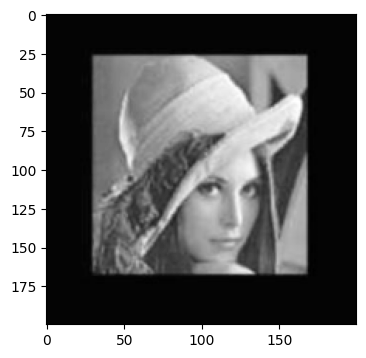

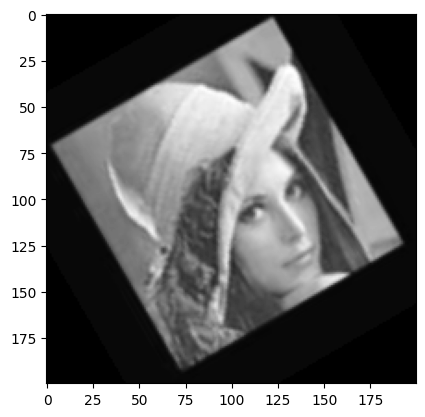

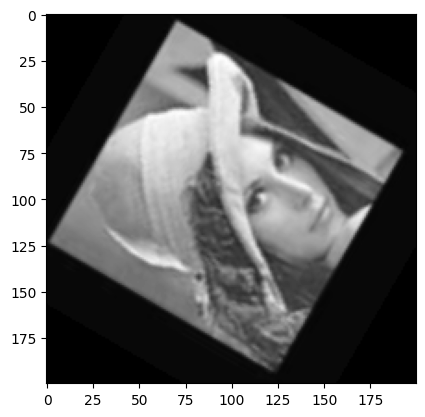

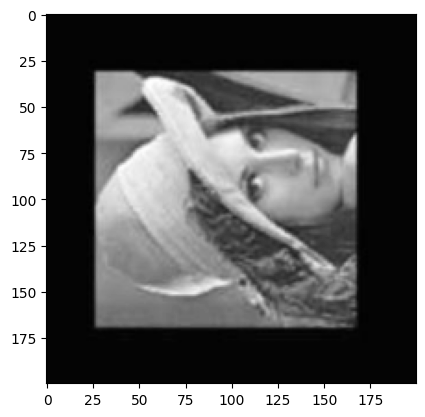

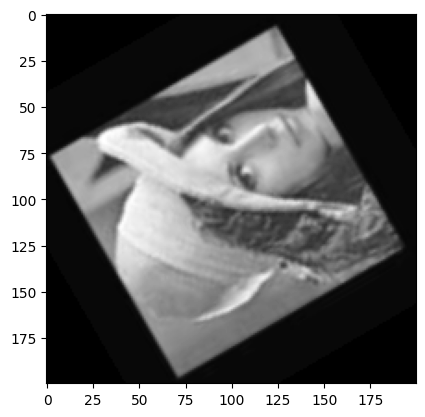

In [32]:
angles = [30, 60, 90, 120]
rotated_images = [rotate_image(lena_image, a) for a in angles]

# display original and rotated images
plt.figure(figsize=(4, 24))
for img in [lena_image] + rotated_images:
    plt.imshow(img, cmap='gray')
    plt.show()

In [33]:
results = experiment_rotation_invariance(
    [lena_image] + rotated_images,
    angles,
    max_order=4
)

Rotation   30°  |  Flusser error = 1.044e+00  |  Derrode error = 1.050e+00
Rotation   60°  |  Flusser error = 9.991e-01  |  Derrode error = 9.792e-01
Rotation   90°  |  Flusser error = 9.725e-01  |  Derrode error = 9.720e-01
Rotation  120°  |  Flusser error = 1.315e+00  |  Derrode error = 1.106e+00


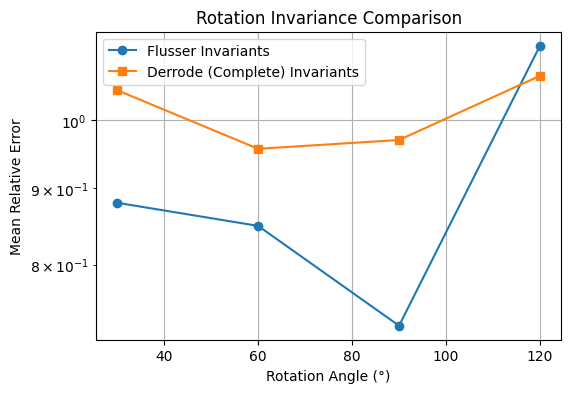

In [24]:
plt.figure(figsize=(6,4))
plt.plot(results['angles'], results['errors_flusser'], 'o-', label='Flusser Invariants')
plt.plot(results['angles'], results['errors_derrode'], 's-', label='Derrode (Complete) Invariants')
plt.xlabel('Rotation Angle (°)')
plt.ylabel('Mean Relative Error')
plt.yscale('log')
plt.title('Rotation Invariance Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
lena_images_path = ["./assets/lena_scale85.png", "./assets/lena_scale90.png", "./assets/lena_scale110.png", "./assets/lena_scale125.png"]

lena_scaled_images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in lena_images_path]
lena_scaled_images = [cv2.resize(img, (200, 200)) for img in lena_scaled_images]

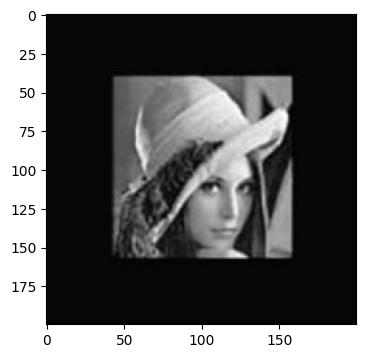

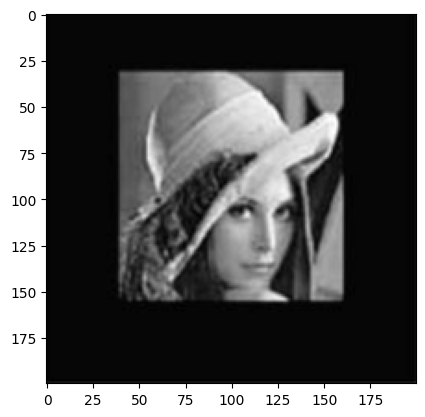

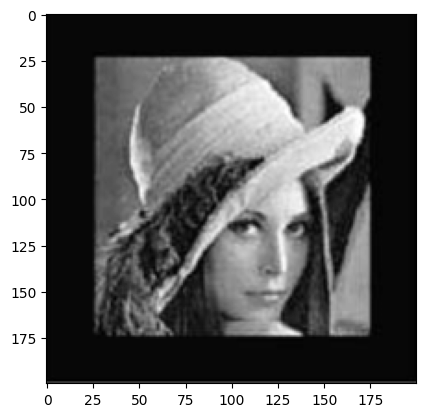

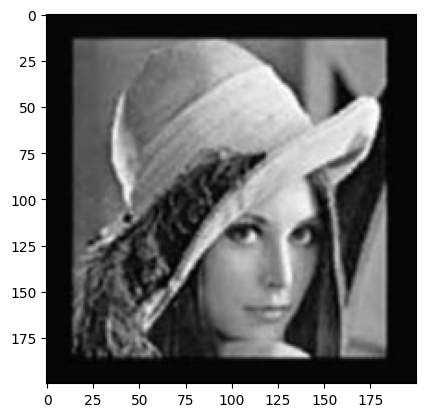

In [27]:
# display original and rotated images
plt.figure(figsize=(4, 24))
for img in lena_scaled_images:
    plt.imshow(img, cmap='gray')
    plt.show()

In [34]:
def experiment_scale_invariance(image_list, scales, max_order=4):
    """
    Evaluate scale invariance of Derrode–Ghorbel invariants.
    """
    # --- Reference (original) ---
    img_ref = image_list[0]
    c_ref, _ = complex_moments(img_ref, max_order)
    derrode_ref, _, _ = derrode_invariants(c_ref, max_order)
    vec_ref = invariant_vector(derrode_ref, max_order)

    errors_derrode = []

    # --- Loop over each scaled image ---
    for i, img_scaled in enumerate(image_list[1:]):
        scale = scales[i]
        c_scaled, _ = complex_moments(img_scaled, max_order)
        derrode_scaled, _, _ = derrode_invariants(c_scaled, max_order)
        vec_scaled = invariant_vector(derrode_scaled, max_order)

        # Eq. (9): mean relative error
        rel_err = np.mean(np.abs(vec_ref - vec_scaled) / (np.abs(vec_ref) ))
        errors_derrode.append(rel_err)

        print(f"Scale {scale:>3}%  ->  Derrode mean relative error = {rel_err:.3e}")

    return {
        'scales': np.array(scales),
        'errors_derrode': np.array(errors_derrode)
    }

In [29]:
# Example: list of Lena images at 85%, 90%, 110%, 125%
lena_scaled_images = [lena_image] + lena_scaled_images  # prepend original
scales = [85, 90, 110, 125]

results_scale = experiment_scale_invariance(lena_scaled_images, scales, max_order=4)

Scale  85%  ->  Derrode mean relative error = 1.665e+00
Scale  90%  ->  Derrode mean relative error = 1.647e+00
Scale 110%  ->  Derrode mean relative error = 1.408e+00
Scale 125%  ->  Derrode mean relative error = 1.270e+00


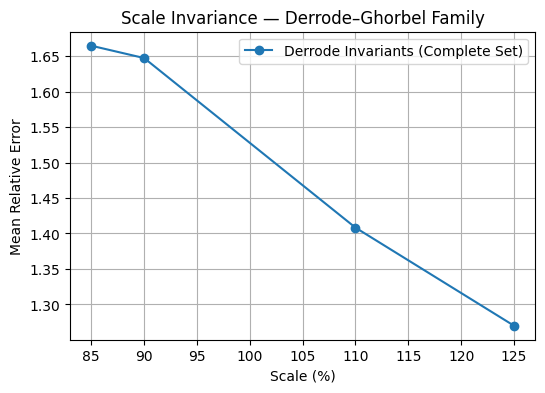

In [35]:
plt.figure(figsize=(6,4))
plt.plot(results_scale['scales'], results_scale['errors_derrode'], 'o-', label='Derrode Invariants (Complete Set)')
plt.xlabel('Scale (%)')
plt.ylabel('Mean Relative Error')
plt.title('Scale Invariance — Derrode–Ghorbel Family')
plt.grid(True)
plt.legend()
plt.show()